# Home Assignment No. 3: Part 1 (Theory and Practice)
To solve this task, you will write a lot of code to try several machine learning methods for dimensionality reduction and anomaly detection.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

## Task 1. Practice with Different Anomaly Detection Algorithms. (5 points)
### Task 1.1. (1 point)
Explore two One-Class SVM methods, write down corresponding minimization functions (try to keep equal notations) and explain the differences (1-2 sentences).
1. Scholkopf et al.: http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf
2. Tax et al.:  https://link.springer.com/content/pdf/10.1023/B:MACH.0000008084.60811.49.pdf

#### Your solution:

$\langle\langle\textbf{Your Latex Code}\rangle\rangle$

### Task 1.2. (2 points)

1. **(1 pt.)** For the `frod_detection` dataset,  predict the anomaly with any three sklearn built-in Anomaly detection methods: https://scikit-learn.org/stable/modules/outlier_detection.html

**Note:** do not forget to relabel predictions from Anomaly detection methods, as they could be negative.

2. **(1 pt.)** Estimate the __contamination__ (or impurity) on the training set as the ratio of anomaly objects in the whole sample. Explore, how the `roc_auc_score` changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [0]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

data = pd.read_csv('data/creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

In [0]:
# impurity estimation on test data

contamination =  test_y.mean()
print(contamination)



0.01693743518838576


array([0, 0, 0, ..., 0, 0, 0])

In [0]:
from sklearn.ensemble import IsolationForest

for i in [0.1, 1, 10]:
    clf = IsolationForest(n_estimators=10, warm_start=True, random_state=2, contamination=i*contamination).fit(train_X, train_y )
    labels_isolation = clf.predict(test_X)
    # Setting new labels
    labels_isolation[labels_isolation==1]=0
    labels_isolation[labels_isolation==-1]=1
    print('Contamination: ', np.round(contamination * i, 3), ' ', 
          'ROC/AUC: ', np.round(roc_auc_score(test_y, labels_isolation  ), 3),
          'Precision: ', np.round(precision_score(test_y, labels_isolation , average = 'micro'), 3))

Contamination:  0.002   ROC/AUC:  0.5 Precision:  0.983
Contamination:  0.017   ROC/AUC:  0.794 Precision:  0.99
Contamination:  0.169   ROC/AUC:  0.811 Precision:  0.846


### Task 1.3. (2 points)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance.

As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. **(1 pt.)** Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 
2. **(1 pt.)**  Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold. Write 1-2 sentences on your findings.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [0]:
# your favorite classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state = 42)
skf.get_n_splits(test_X, test_y)

roc_auc_score_list = []
pr_score = []

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<
    clf = RandomForestClassifier()
    X_train= test_X.iloc[train_index]
    X_test = test_X.iloc[test_index]
    y_train = test_y.iloc[train_index]
    y_test = test_y.iloc[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    roc = roc_auc_score(y_test, y_pred)
    roc_auc_score_list += [roc]
    prec = precision_score(y_test, y_pred, average = 'micro')
    pr_score += [prec]
    
print('ROC/AUC mean: ', np.mean(roc_auc_score_list), 'std: ', np.std(roc_auc_score_list))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


ROC/AUC mean:  0.8994718309859155 std:  0.10970807709609622
Precision mean:  0.9955065028039615 std:  0.004386008872439553


In [0]:
# ensemble of classifiers
skf = StratifiedKFold(n_splits=10, random_state = 42)
skf.get_n_splits(test_X, test_y)

roc_auc_score = []
pr_score = []

ifc = IsolationForest(random_state = 42)


for train_index, test_index in skf.split(test_X, test_y):

    # >>> your solution here <<<
    
print('ROC/AUC mean: ', np.mean(roc_auc_score), 'std: ', np.std(roc_auc_score))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))

ROC/AUC mean:  0.5866329494757112 std:  0.020943388474316184
Precision mean:  0.8821428571428571 std:  0.1282679398723351


In [0]:
# Write 1-2 sentences on your findings.

## Task 2. Practice with Different Clustering Algorithms. (4 points)
### Task 2.1. Explore KMeans and Gaussian Mixture algorithms. (2 points)
Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. **(1 pt.)** Apply the algorithm with the true number of clusters and at least two **other settings** for the number of clusters: a smaller and a larger number than the true one;
2. **(1 pt.)** For each number of clusters **vizualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

True number of clusters is 15


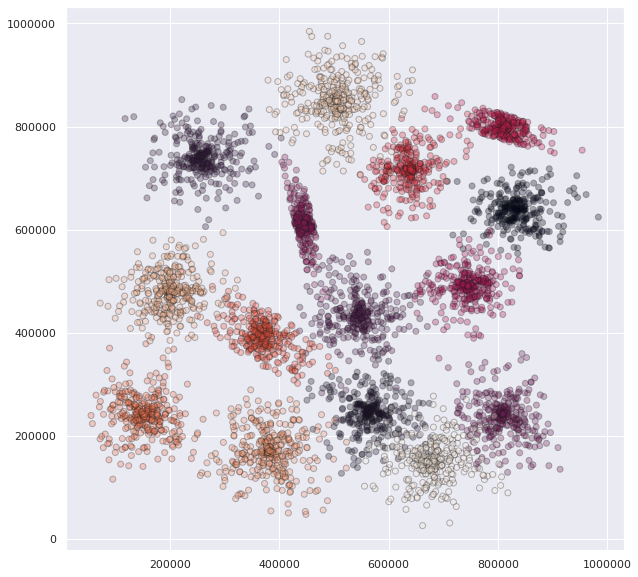

In [0]:
points, labels = np.loadtxt('data/clustering.txt'), np.loadtxt('data/clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [0]:
### BEGIN Solution
from sklearn.cluster import KMeans, Birch, AffinityPropagation, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler


# >>> your solution here <<<

### END Solution

Text(0.5, 1.0, 'GaussianMixture n_clusters=20')

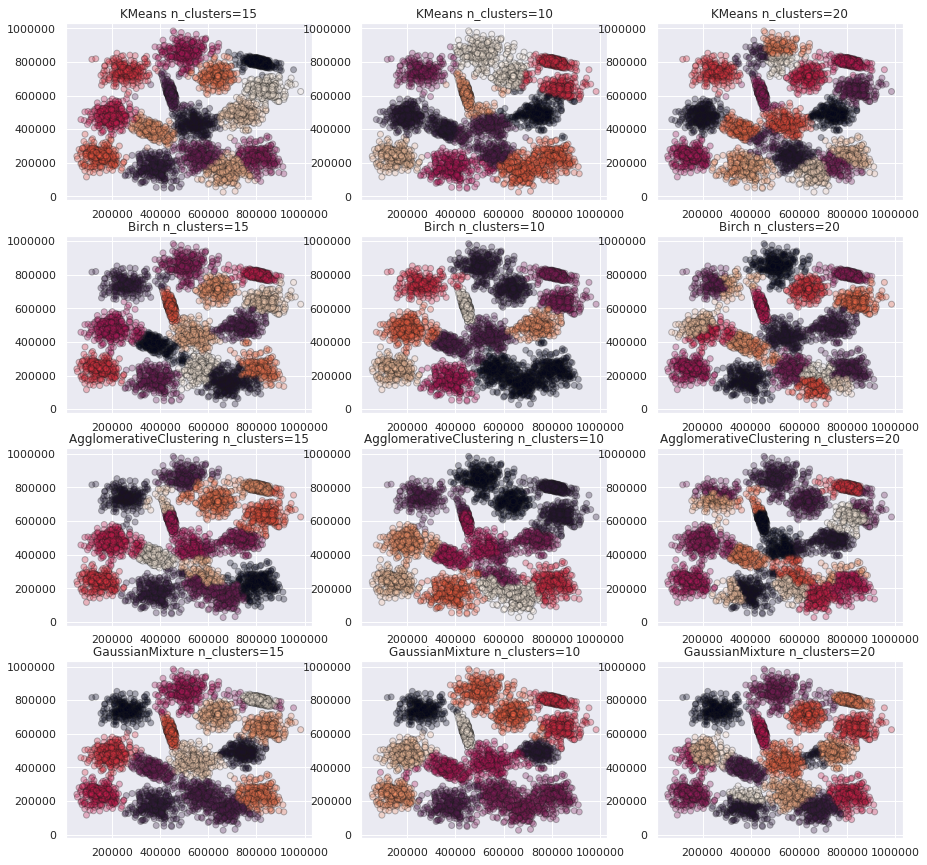

In [0]:
# Apply the algorithm with the true number of clusters and at least two other
# settings for the number of clusters: a smaller and a larger number than the true one;

### BEGIN Solution

km15 = KMeans(n_clusters=15, random_state = 2, max_iter =300, n_jobs = -1).fit(points)
km10 = KMeans(n_clusters=10, random_state = 2, max_iter =300, n_jobs = -1 ).fit(points)
km20 = KMeans(n_clusters=20, random_state = 2, max_iter =300, n_jobs = -1).fit(points)
birch15 = Birch(n_clusters=15, branching_factor=40).fit(points)
birch10 = Birch(n_clusters=10, branching_factor=40).fit(points)
birch20 = Birch(n_clusters=20, branching_factor=40).fit(points)
aggc15 = AgglomerativeClustering(n_clusters=15, affinity = 'euclidean', linkage = 'complete').fit(points)
aggc10 = AgglomerativeClustering(n_clusters=10, affinity = 'euclidean' , linkage = 'complete').fit(points)
aggc20 = AgglomerativeClustering(n_clusters=20, affinity = 'euclidean', linkage = 'complete').fit(points)
gm15 = GaussianMixture(n_components=15, random_state=2).fit_predict(points)
gm10 = GaussianMixture(n_components=10, random_state=2).fit_predict(points)
gm20 = GaussianMixture(n_components=20, random_state=2).fit_predict(points)

plt.figure(figsize=(15, 15))
plt.subplot(4,3,1)
plt.title('KMeans n_clusters=15')
plt.scatter(points[:,0], points[:,1], c=km15.labels_, alpha=0.3, edgecolor='k')
plt.subplot(4,3,2)
plt.scatter(points[:,0], points[:,1], c=km10.labels_, alpha=0.3, edgecolor='k')
plt.title('KMeans n_clusters=10')
plt.subplot(4,3,3)
plt.scatter(points[:,0], points[:,1], c=km20.labels_, alpha=0.3, edgecolor='k')
plt.title('KMeans n_clusters=20')
plt.subplot(4,3,4)
plt.title('Birch n_clusters=15')
plt.scatter(points[:,0], points[:,1], c=birch15.labels_, alpha=0.3, edgecolor='k')
plt.subplot(4,3,5)
plt.scatter(points[:,0], points[:,1], c=birch10.labels_, alpha=0.3, edgecolor='k')
plt.title('Birch n_clusters=10')
plt.subplot(4,3,6)
plt.scatter(points[:,0], points[:,1], c=birch20.labels_, alpha=0.3, edgecolor='k')
plt.title('Birch n_clusters=20')
plt.subplot(4,3,7)
plt.title('AgglomerativeClustering n_clusters=15')
plt.scatter(points[:,0], points[:,1], c=aggc15.labels_, alpha=0.3, edgecolor='k')
plt.subplot(4,3,8)
plt.scatter(points[:,0], points[:,1], c=aggc10.labels_, alpha=0.3, edgecolor='k')
plt.title('AgglomerativeClustering n_clusters=10')
plt.subplot(4,3,9)
plt.scatter(points[:,0], points[:,1], c=aggc20.labels_, alpha=0.3, edgecolor='k')
plt.title('AgglomerativeClustering n_clusters=20')
plt.subplot(4,3,10)
plt.title('GaussianMixture n_clusters=15')
plt.scatter(points[:,0], points[:,1], c=gm15, alpha=0.3, edgecolor='k')
plt.subplot(4,3,11)
plt.scatter(points[:,0], points[:,1], c=gm10, alpha=0.3, edgecolor='k')
plt.title('GaussianMixture n_clusters=10')
plt.subplot(4,3,12)
plt.scatter(points[:,0], points[:,1], c=gm20, alpha=0.3, edgecolor='k')
plt.title('GaussianMixture n_clusters=20')

### END Solution

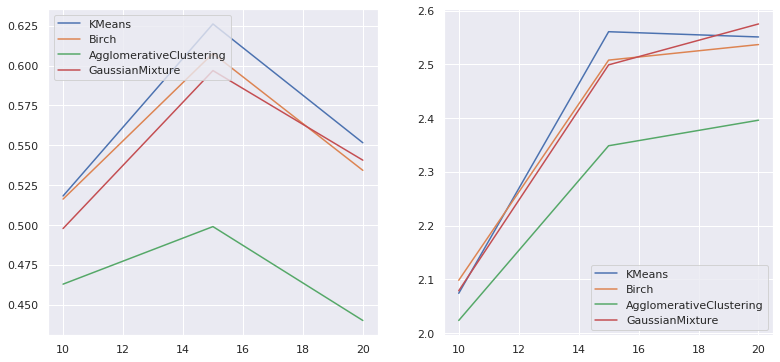

In [0]:
# vizualize the clustering result, calculate the clustering metrics and plot them;
### BEGIN Solution

km_ss = [silhouette_score(points, km10.labels_),silhouette_score(points, km15.labels_), silhouette_score(points, km20.labels_)]
birch_ss = [silhouette_score(points, birch10.labels_),silhouette_score(points, birch15.labels_), silhouette_score(points, birch20.labels_)]
aggc_ss = [silhouette_score(points, aggc10.labels_),silhouette_score(points, aggc15.labels_), silhouette_score(points, aggc20.labels_)]
gm_ss = [silhouette_score(points, gm10),silhouette_score(points, gm15), silhouette_score(points, gm20)]

km_mit = [mutual_info_score(labels, km10.labels_ ),mutual_info_score(labels, km15.labels_), mutual_info_score(labels, km20.labels_)]
birch_mit = [mutual_info_score(labels, birch10.labels_),mutual_info_score(labels, birch15.labels_), mutual_info_score(labels, birch20.labels_)]
aggc_mit = [mutual_info_score(labels, aggc10.labels_),mutual_info_score(labels, aggc15.labels_), mutual_info_score(labels, aggc20.labels_)]
gm_mit = [mutual_info_score(labels, gm10),mutual_info_score(labels, gm15), mutual_info_score(labels, gm20)]

plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.plot([10, 15, 20], km_ss)
plt.plot([10, 15, 20], birch_ss)
plt.plot([10, 15, 20], aggc_ss)
plt.plot([10, 15, 20], gm_ss)
labels1 = ['KMeans', 'Birch', 'AgglomerativeClustering', 'GaussianMixture']
plt.legend(labels1, loc = 'upper left')
plt.subplot(1,2,2)
plt.plot([10, 15, 20], km_mit)
plt.plot([10, 15, 20], birch_mit)
plt.plot([10, 15, 20], aggc_mit)
plt.plot([10, 15, 20], gm_mit)
labels1 = ['KMeans', 'Birch', 'AgglomerativeClustering', 'GaussianMixture']
plt.legend(labels1, loc = 'lower right')
### END Solution

### Task 2.2. Finding the Number of Clusters with Bootstrap. (2 points)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. **(1 pt.)** Estimate variance of the metric and construct normal 95% **confidence interval (CI)**;
2. **(1 pt.)** **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__  
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

Number of clusters: 10 
Variance 0.00010447204710008014 
Confidence interval: (0.4993239822735444, 0.5373589364648393)


Number of clusters: 11 
Variance 9.618165442153678e-05 
Confidence interval: (0.520600388138698, 0.5578488671845024)


Number of clusters: 12 
Variance 8.703567099343772e-05 
Confidence interval: (0.5491039990736899, 0.5806762944009863)


Number of clusters: 13 
Variance 5.83594801932025e-05 
Confidence interval: (0.5722818770849271, 0.5988104167005027)


Number of clusters: 14 
Variance 7.394660270261079e-05 
Confidence interval: (0.5992871256236603, 0.6278896866071128)


Number of clusters: 15 
Variance 5.7659628112791364e-05 
Confidence interval: (0.6116282441630392, 0.6411299302589534)


Number of clusters: 16 
Variance 4.176253204128939e-05 
Confidence interval: (0.5970268093726264, 0.6223052039818772)


Number of clusters: 17 
Variance 7.214128750256674e-05 
Confidence interval: (0.5783472576152597, 0.6087361714639546)


Number of clusters: 18 
Variance 6.917364963056489e-05 
Confidence interval: (0.5617414816598455, 0.592620557931949)


Number of clusters: 19 
Variance 0.00016905041605884354 
Confidence interval: (0.5410846847449986, 0.5886130222153553)


Text(0, 0.5, 'Silhouette score')

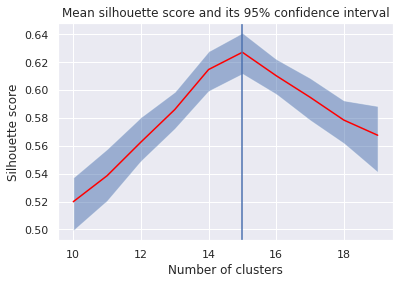

In [0]:
import scipy
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook, tqdm

### BEGIN Solution

cluster_ns = range(10,20)
sample_number = 50
nb_examples = points.shape[0]

Mean_all = []
Interval_lower = []
Interval_upper = []
for i, n_clusters in tqdm_notebook(enumerate(cluster_ns)):
  j=0
  Metrics = []
  for i, num_of_sample in tqdm_notebook(enumerate(range(sample_number))):
    points_sub = points[np.random.randint(0, nb_examples, size=int(nb_examples/3))]
    km = KMeans(n_clusters=n_clusters, n_jobs = -1).fit(points_sub)
    Metrics += [silhouette_score(points_sub, km.labels_)]
    j+=1
  variance = np.var(Metrics)
  mean = np.mean(Metrics)
  Mean_all += [mean]
  interval = scipy.stats.norm.interval(alpha = 0.95, loc = mean, scale = variance )
  i_l = np.percentile(Metrics, 2.5)
  i_u = np.percentile(Metrics, 97.5)
  Interval_lower += [i_l]
  Interval_upper += [i_u]
  print('Number of clusters:', n_clusters,'\nVariance', variance,
        '\nConfidence interval:', (i_l, i_u))
plt.title('Mean silhouette score and its 95% confidence interval')
plt.fill_between(range(10,20), Interval_lower, Interval_upper, alpha=.5)
plt.plot(range(10,20), Mean_all, c  = 'red')
plt.axvline(np.argmax(Mean_all)+10)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
### END Solution

## Task 3. MNIST, kMNIST component analysis and manifold learning. (6 points)
### Task 3.1. (2 points)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimentionality, decompose the dataset on pinciple components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case use can use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. **(1 pt.)** Estimate the intrinsic dimentionality of the dataset. Provide the plot.
2. **(1 pt.)** Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [0]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sns.set()

dg = datasets.load_digits()

data = StandardScaler().fit_transform(dg.data)

In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstanec betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/p

Text(0, 0.5, 'Intrinsic dimensionality')

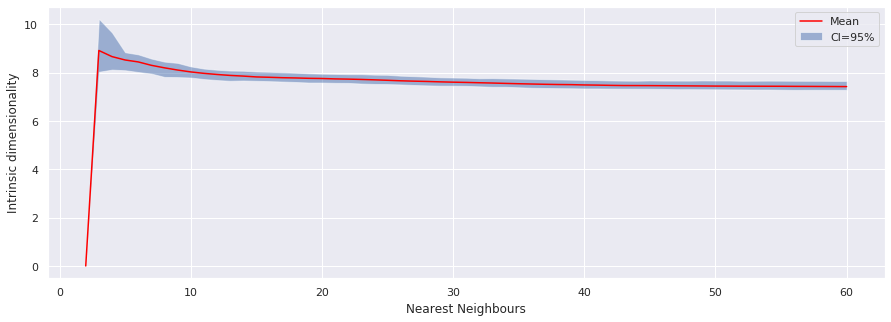

In [0]:
# Estimate the intrinsic dimentionality of the dataset. 

### BEGIN Solution
k1 = 2
k2 = 60
intdim_k_repeated = repeated(func = intrinsic_dim_scale_interval, X = data, mode='bootstrap',  k1=k1, k2=k2, nb_iter=20)
intdim_k_repeated = np.array(intdim_k_repeated)
Mean_all = []
Interval_lower = []
Interval_upper = []
for i in range(intdim_k_repeated.shape[1]):
  mean = np.mean(intdim_k_repeated.T[i])
  Mean_all += [mean]
  i_l = np.percentile(intdim_k_repeated.T[i], 2.5)
  i_u = np.percentile(intdim_k_repeated.T[i], 97.5)
  Interval_lower += [i_l]
  Interval_upper += [i_u]
plt.figure(figsize=(15,5))
plt.fill_between(range(2,61), Interval_lower, Interval_upper, alpha=.5)
plt.plot(range(2,61), Mean_all, c  = 'red')
plt.legend(labels = ['Mean', 'CI=95%'])
plt.xlabel('Nearest Neighbours')
plt.ylabel('Intrinsic dimensionality')


### END Solution

Text(0, 0.5, 'Cumulative explained variance')

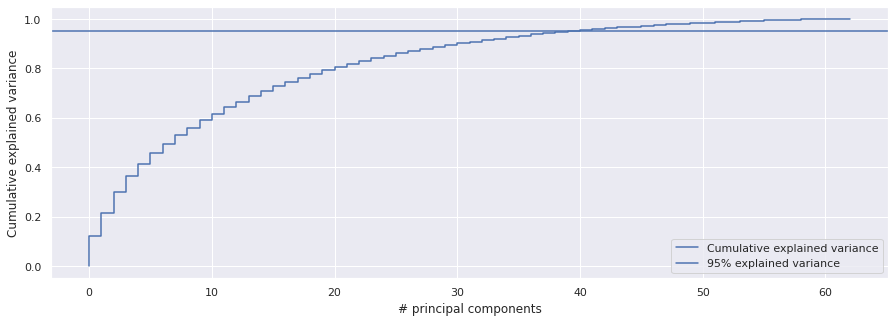

In [0]:
# Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component.
from sklearn.decomposition import PCA

### BEGIN Solution
cum_expl_var = []
for i in range(63):
  pca = PCA(n_components = i)
  pca.fit_transform(data)
  cum_expl_var += [np.sum(pca.explained_variance_ratio_)]
plt.figure(figsize=(15,5))
plt.step(range(0, 63), cum_expl_var)
plt.axhline(0.95)
plt.legend(labels = ['Cumulative explained variance', '95% explained variance'])
plt.xlabel('# principal components')
plt.ylabel('Cumulative explained variance')
# >>> your solution here <<<

### END Solution

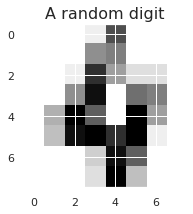

In [0]:
# Plot the example of back-decomposition with 6 different 
# set of components and corresponding explained variance. You can choose any digit from the dataset.

plt.figure(5, figsize=(3, 3))
plt.imshow(dg.images[4], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('A random digit', fontsize=16)
plt.show()

y = dg.target
X = dg.images.reshape(-1, 8*8) / dg.images.max()

Text(0.5, 1.0, '70% of Explained Variance')

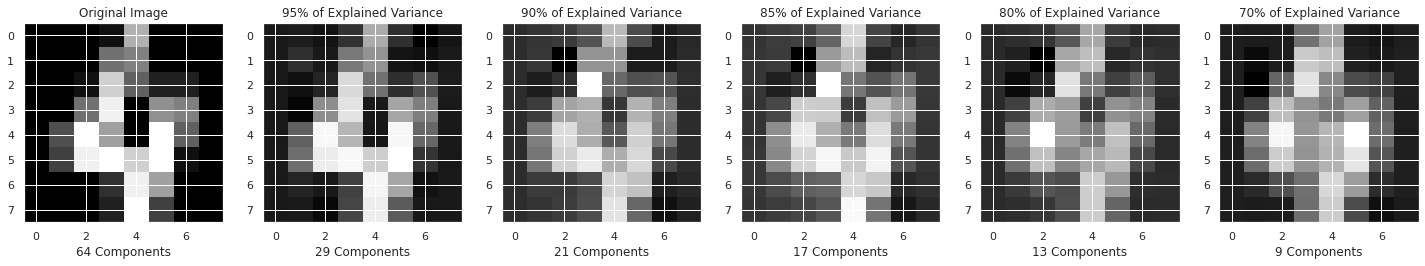

In [0]:
### BEGIN Solution

def expl_var(expl_var_ratio, dig_imag): 
  pca = PCA(expl_var_ratio)
  pca.fit(dig_imag)
  dig_imag_transformed = pca.transform(dig_imag)
  dig_imag_inversed = pca.inverse_transform(dig_imag_transformed)
  return dig_imag_inversed

plt.figure(figsize=(25,5))

plt.subplot(1, 6, 1)
plt.imshow(X[4].reshape(8,8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('64 Components')
plt.title('Original Image')

plt.subplot(1, 6, 2)
plt.imshow(expl_var(0.95, X)[4].reshape(8, 8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('29 Components')
plt.title('95% of Explained Variance')

plt.subplot(1, 6, 3)
plt.imshow(expl_var(0.9, X)[4].reshape(8, 8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('21 Components')
plt.title('90% of Explained Variance')

plt.subplot(1, 6, 4)
plt.imshow(expl_var(0.85, X)[4].reshape(8, 8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('17 Components')
plt.title('85% of Explained Variance')

plt.subplot(1, 6, 5)
plt.imshow(expl_var(0.8, X)[4].reshape(8, 8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('13 Components')
plt.title('80% of Explained Variance')

plt.subplot(1, 6, 6)
plt.imshow(expl_var(0.7, X)[4].reshape(8, 8),
              cmap = plt.cm.gray, interpolation='nearest')
plt.xlabel('9 Components')
plt.title('70% of Explained Variance')
### END Solution

### Task 3.2. (2 points)

Here we will visualise the decomposition in order to observe how data diverges across different manofild learning methods. We are  to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracy on the new features. 

1. Visualise ICA, PCA and Isomap 3D decomposition on 3 components in `plotly`. Make sure the data is whitened (scaled), enjoy nice plots :) 
2. **(1 pt.)** Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimention**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
3. **(1 pt.)** Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 senteces.

__NOTE:__ In first task, `plotly` will not display the plot in offline notebook, so it is just for you to visualize the projection in 3D.

In [0]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import colorlover as cl

init_notebook_mode(connected=True)

In [0]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap
### BEGIN Solution

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
S_pca_ = pca.fit_transform(X_scaled)

### END Solution

In [0]:
digits_3d = pd.DataFrame({
    'x': S_pca_[:, 0], 
    'y': S_pca_[:, 1], 
    'z': S_pca_[:, 2],
    'label': dg['target'],
})

colors = cl.scales['10']['qual']['Paired']
data = []

for i in range(10):
    x = digits_3d[digits_3d['label'].astype('int') == i]['x']
    y = digits_3d[digits_3d['label'].astype('int') == i]['y']
    z = digits_3d[digits_3d['label'].astype('int') == i]['z']
    
    color = colors[i]
    
    trace = {
        'name': str(i),
        'x': x,
        'y': y,
        'z': z,
        'type': 'scatter3d',
        'mode': 'markers',
        'marker': {
            'size': 5,
            'color': color 
        }
    }
    data.append(trace)

layout = go.Layout(
    title='MNIST visualization PCA',
    width=900,
    height=600
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link = False)

In [0]:
from IPython.display import Image
Image("pca.png")

In [0]:
# Calculate new features on the data with ICA, PCA and Isomap and the classification accuracy on these features 

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')
rkf = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 42 )

### BEGIN Solution
from sklearn.metrics import accuracy_score
y = dg.target
pca = PCA(n_components=64)
fica = FastICA(n_components=64)
imap = Isomap(n_components=64)
X_pca = pca.fit_transform(X_scaled)
X_fica = fica.fit_transform(X_scaled)
X_imap = imap.fit_transform(X_scaled)
logreg.fit(X_pca, y)
logreg.predict(X_pca)
accuracy_pca = []
accuracy_fica = []
accuracy_imap = []
for train_index, test_index in rkf.split(X):
  logreg.fit(X_pca[train_index], y[train_index])
  y_pred_pca = logreg.predict(X_pca[test_index])

  logreg.fit(X_fica[train_index], y[train_index])
  y_pred_fica = logreg.predict(X_fica[test_index])

  logreg.fit(X_imap[train_index], y[train_index])
  y_pred_imap = logreg.predict(X_imap[test_index])

  accuracy_pca += [accuracy_score(y[test_index], y_pred_pca)]
  accuracy_fica += [accuracy_score(y[test_index], y_pred_fica)]
  accuracy_imap += [accuracy_score(y[test_index], y_pred_imap)]



scores = list()

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also

In [0]:
X

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

In [0]:
# >>> your solution here <<<

,dim.reduction method,mean accuracy,std
1,PCA,0.933039,0.0101131
2,ICA,0.85773,0.0212201
3,Isomap,0.974777,0.00965627


In [0]:
# >>> your solution here <<<

Statistically significant improvement of PCA decomposition over ICA: p-value  2.085472799316657e-17


In [0]:
# >>> your solution here <<<

### END Solution

Statistically significant improvement of Isomap decomposition over PCA: p-value  7.9465832147781e-12


### Task 3.3. kMNIST dimensionality reduction. (2 points)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engeneer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than `93%`. Is it fair to `fit` with manifold Learning method for both train and test samples? 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`, you will find it in __Part 2__.  Save 3 first components of your projection on `train` sample to `.csv`, we are going to visually compare them later.


In [0]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.decomposition import PCA

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

### BEGIN Solution

# >>> your solution here <<<

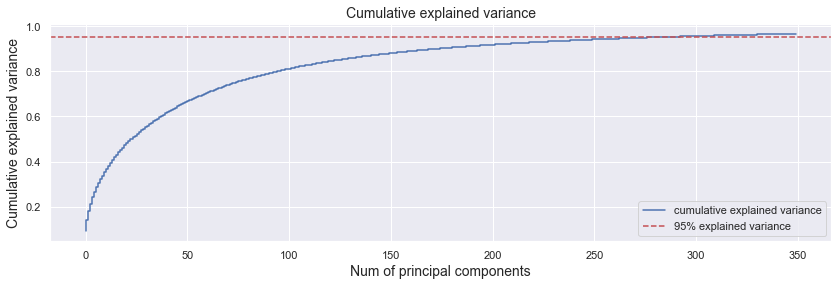

In [0]:
# >>> your solution here <<<

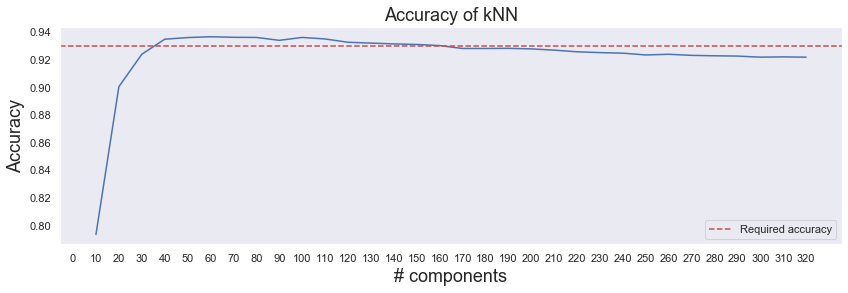

In [0]:
# >>> your solution here <<<
### END Solution

#### Voilla! you are done, have a good day ;)